In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import terra
import meerkat as mk
from domino.data.visual_genome import get_dps, ATTRIBUTE_GROUPS
import numpy as np

## Create DataPanels for the Visual Genome

`image_dp` - each row corresponds to an image in the dataset  
`object_dp`– each row corresponds to an object (e.g. 'car') in one of the images  
`attr_dp`- each row maps an attribute (e.g. 'red') to an object

In [7]:
image_dp, attr_dp, object_dp = get_dps()

,image_id (NumpyArrayColumn),height (NumpyArrayColumn),url (PandasSeriesColumn),width (NumpyArrayColumn),index (PandasSeriesColumn),local_path (PandasSeriesColumn),image (ImageColumn),h (NumpyArrayColumn),name (PandasSeriesColumn),object_id (NumpyArrayColumn),syn_name (PandasSeriesColumn),w (NumpyArrayColumn),x (NumpyArrayColumn),y (NumpyArrayColumn),object_image (LambdaColumn)
0,1.0,600.0,https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg,800.0,0,/home/common/datasets/visual-genome/VG_100K_2/1.jpg,,339.0,clock,1058498.0,clock.n.01,79.0,421.0,91.0,
1,1.0,600.0,https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg,800.0,1,/home/common/datasets/visual-genome/VG_100K_2/1.jpg,,262.0,street,5046.0,street.n.01,714.0,77.0,328.0,
2,1.0,600.0,https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg,800.0,2,/home/common/datasets/visual-genome/VG_100K_2/1.jpg,,192.0,shade,5045.0,shade.n.01,274.0,119.0,338.0,
3,1.0,600.0,https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg,800.0,3,/home/common/datasets/visual-genome/VG_100K_2/1.jpg,,262.0,man,1058529.0,man.n.01,60.0,238.0,249.0,
4,1.0,600.0,https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg,800.0,4,/home/common/datasets/visual-genome/VG_100K_2/1.jpg,,26.0,sneakers,5048.0,gym_shoe.n.01,52.0,243.0,489.0,
5,1.0,600.0,https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg,800.0,5,/home/common/datasets/visual-genome/VG_100K_2/1.jpg,,15.0,headlight,5050.0,headlight.n.01,23.0,514.0,366.0,
6,1.0,600.0,https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg,800.0,6,/home/common/datasets/visual-genome/VG_100K_2/1.jpg,,98.0,car,5049.0,car.n.01,74.0,479.0,315.0,
7,1.0,600.0,https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg,800.0,7,/home/common/datasets/visual-genome/VG_100K_2/1.jpg,,34.0,bike,5051.0,bicycle.n.01,28.0,318.0,319.0,
8,1.0,600.0,https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg,800.0,8,/home/common/datasets/visual-genome/VG_100K_2/1.jpg,,35.0,bike,1058535.0,bicycle.n.01,29.0,334.0,319.0,
9,1.0,600.0,https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg,800.0,9,/home/common/datasets/visual-genome/VG_100K_2/1.jpg,,182.0,sign,1058507.0,sign.n.02,88.0,118.0,13.0,

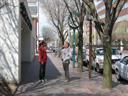
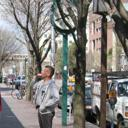
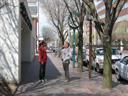
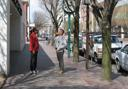
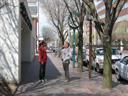
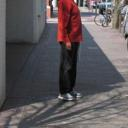
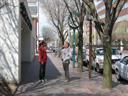
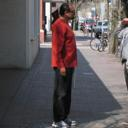
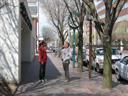
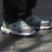
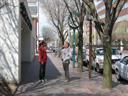
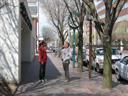
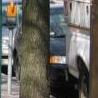
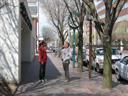
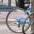
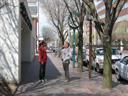
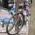
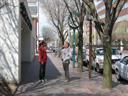
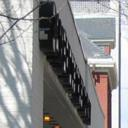
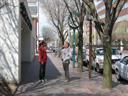
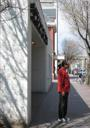
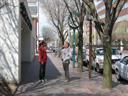
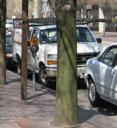
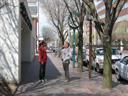
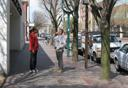
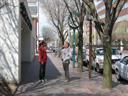
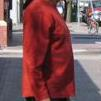
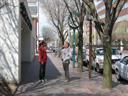
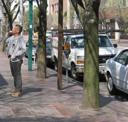
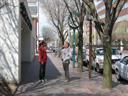
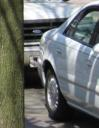
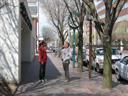
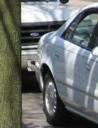
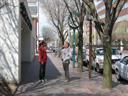
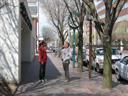
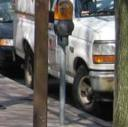
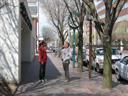
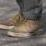
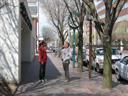
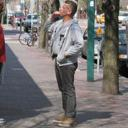
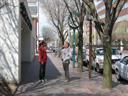
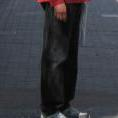
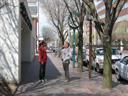
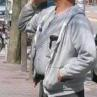
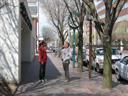
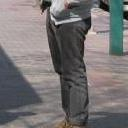
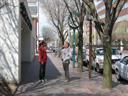
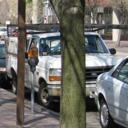
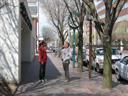
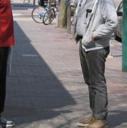
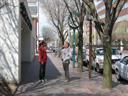
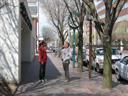
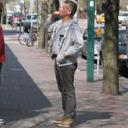
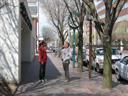
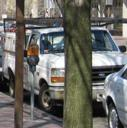
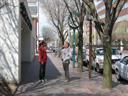
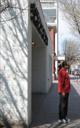
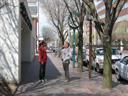
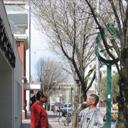
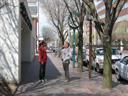
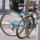
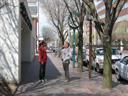
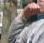
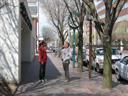
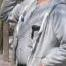
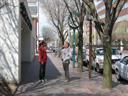
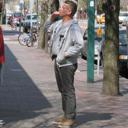
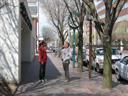
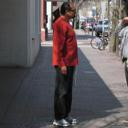
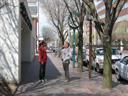
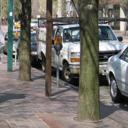
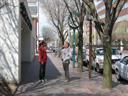
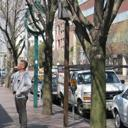
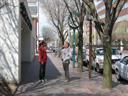
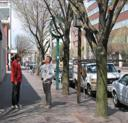
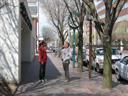
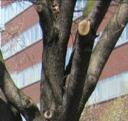
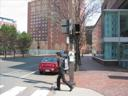
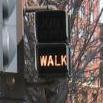
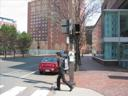
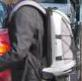
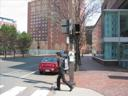
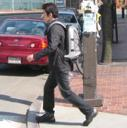
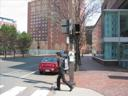
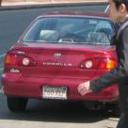
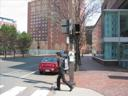
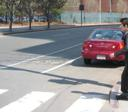
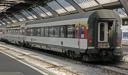
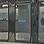
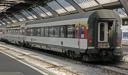
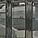
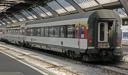
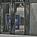
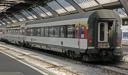
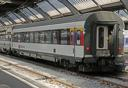
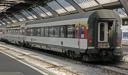
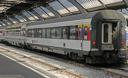
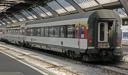
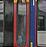
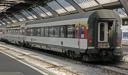
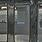
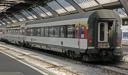
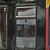
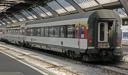
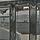
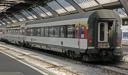
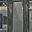
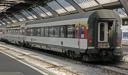
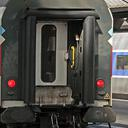
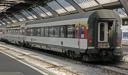
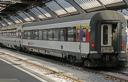
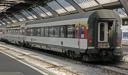
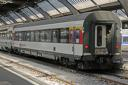
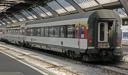
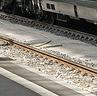
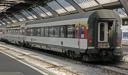
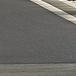
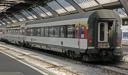
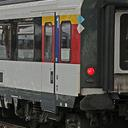
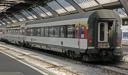
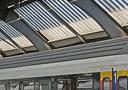
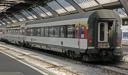
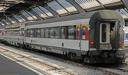
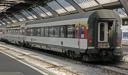
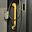
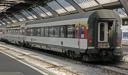
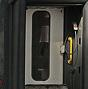
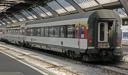
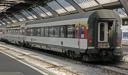
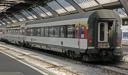
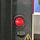
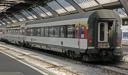
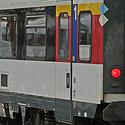
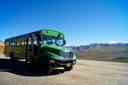
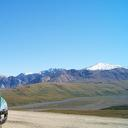
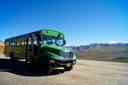
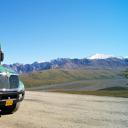
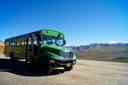
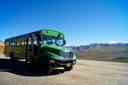
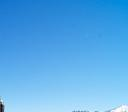
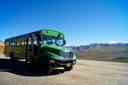
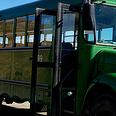
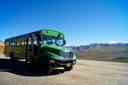
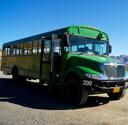
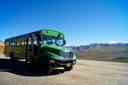
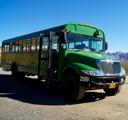
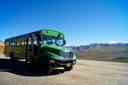
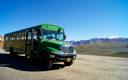
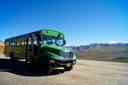
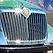
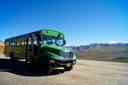
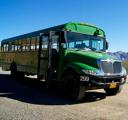
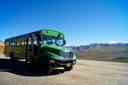
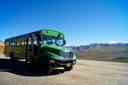
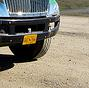
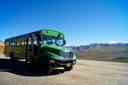
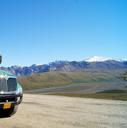
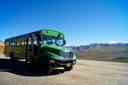
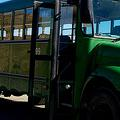
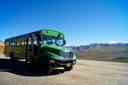
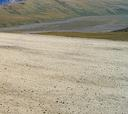
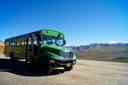
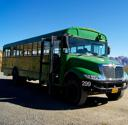
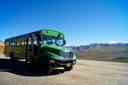
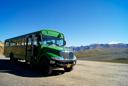
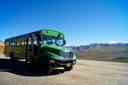
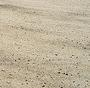
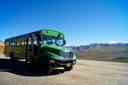
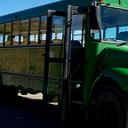
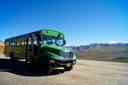
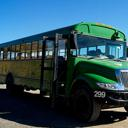
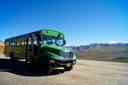
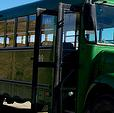

In [21]:
object_dp

## Create a classification task
We're going to use the visual genome to craft a binary image classification task.  
`target` = 1 if the object is a car and `target` = 0 otherwise. 

We're also going to keep track of a potential confounder: "color". 

In [8]:
# filter to only include objects with an annotated color 
colored_objects = attr_dp["object_id"][
    attr_dp["attribute"].isin(ATTRIBUTE_GROUPS["colors"])
]
dp = object_dp.lz[np.isin(object_dp["object_id"], colored_objects)]

# set the target column to "is car?"
dp["target"] = dp["syn_name"].isin(["car.n.01"]).values.astype(int)

# set the correlate column to "is red?"
red_objects = attr_dp["object_id"][
    attr_dp["attribute"].isin(["red"])
]
dp["correlate"] = np.isin(dp["object_id"], red_objects).astype(int)

,(LambdaColumn)
0,
1,
2,
3,
4,
...,...
1429,
1430,
1431,
1432,

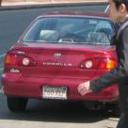
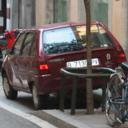
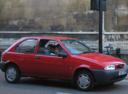
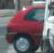
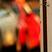
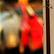
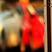
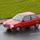
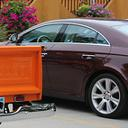

In [9]:
dp.lz[(dp["target"] & dp["correlate"]) == 1]["object_image"]

## Induce correlation
Let's induce an artificial correlation between cars and the color red.

In [18]:
from domino.evaluate.linear import induce_correlation

In [33]:
indices = induce_correlation(
    dp, 
    corr=0.8, 
    mu_a=0.05,
    mu_b=0.05,
    attr_a="target", 
    attr_b="correlate", 
    n=2e4
)
dataset_dp = dp.lz[indices]

In [34]:
from scipy.stats import pearsonr
pearsonr(dataset_dp["target"], dataset_dp["correlate"])

(0.7998092834663161, 0.0)

## Train a Model
Train a model on this subsampled dataset

In [35]:
from domino.utils import split_dp

In [36]:
dataset_dp = split_dp(dataset_dp, split_on="image_id")

In [148]:
import terra 
from domino.vision import train
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
preprocessing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

dataset_dp["input"] = dataset_dp["object_image"].to_lambda(preprocessing)

@terra.Task.make_task
def train_vg(dp, run_dir: str = None):

    model = train(
        config={"pretrained": True},
        dp=dp,
        input_column="input",
        id_column="object_id",
        target_column="target",
        ckpt_monitor="valid_auroc",
        batch_size=128, 
        run_dir=run_dir,
        val_check_interval=10,
        num_workers=6
    )
    return model
train_vg(dp=dataset_dp)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [10]:
run_id = 4513
dataset_dp = terra.inp(run_id)["dp"].load()
model = terra.get_artifacts(run_id, "best_chkpt")["model"]

## Score model
Let's score the model and evaluate on subgroups.

In [11]:
from domino.vision import score
score_dp = score(
    model=model.load(), 
    dp=dataset_dp.lz[dataset_dp["split"] == "test"], 
    input_column="input",
    batch_size=128
)

/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [12]:
score_dp["prob"] = score_dp["output"].probabilities().data[:, -1]

In [13]:
from sklearn.metrics import roc_auc_score
print("Overall AUROC: {}".format(
    roc_auc_score(score_dp["target"], score_dp["prob"])
))

curr_dp = score_dp.lz[score_dp["target"] == score_dp["correlate"]]
print("AUROC where correlation holds: {}".format(
    roc_auc_score(curr_dp["target"], curr_dp["prob"])
))

curr_dp = score_dp.lz[score_dp["target"] != score_dp["correlate"]]
print("AUROC where correlation does not hold: {}".format(
    roc_auc_score(curr_dp["target"], curr_dp["prob"])
))

Overall AUROC: 0.9178055100927441
AUROC where correlation holds: 0.9547952982034328
AUROC where correlation does not hold: 0.34175084175084175


## Embed in CLIP space to recover spurious correlate

In [14]:
from domino.clip import embed_images
score_dp = embed_images(dp=score_dp, img_column="object_image")

In [15]:
from domino.clip import embed_words, get_wiki_words
#words_dp = get_wiki_words()
#words_dp = embed_words(words_dp).load()
words_dp = embed_words.out(4517).load()
words_dp = words_dp.lz[:int(1e4)]

,object_image (LambdaColumn),prob (TensorColumn),target (NumpyArrayColumn),correlate (NumpyArrayColumn)
0,,tensor(0.7819),0,0
1,,tensor(0.7003),0,0
2,,tensor(0.7477),0,0
3,,tensor(0.6335),0,0
4,,tensor(0.5642),0,0
5,,tensor(0.6179),0,0
6,,tensor(0.7875),0,0
7,,tensor(0.5850),0,1
8,,tensor(0.8685),0,0
9,,tensor(0.7502),0,0

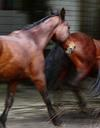
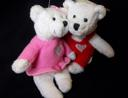
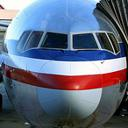
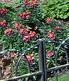
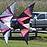
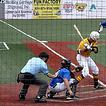
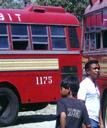
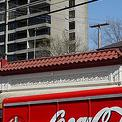
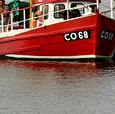
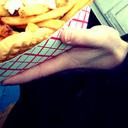
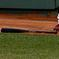
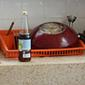
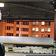
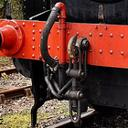
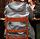
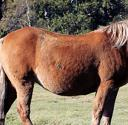
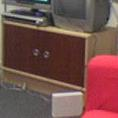
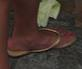
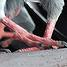
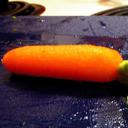
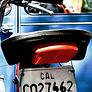
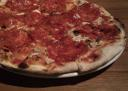
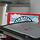
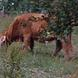
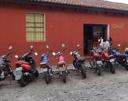
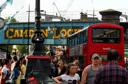
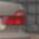
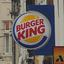
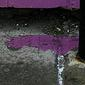
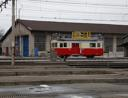
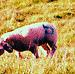
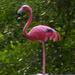
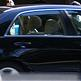
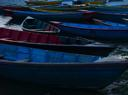
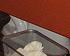
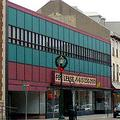
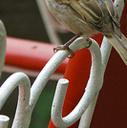

In [20]:
mk.config.DisplayOptions.max_rows = 91
error_dp = score_dp.lz[(score_dp["prob"] > 0.5).numpy() != (score_dp["target"] == 1)]
error_dp = error_dp.lz[(error_dp["target"] == 0)]
error_dp[["object_image", "prob", "target", "correlate"]]

In [22]:
dp = score_dp
attr_emb = dp.lz[(dp["prob"] > 0.5).numpy()]["emb"].data.numpy().mean(axis=0)
ref_emb = dp.lz[dp["target"] == 1]["emb"].data.numpy().mean(axis=0)

scores = np.dot( 
    words_dp["emb"].data.numpy(),   
    (attr_emb - ref_emb) 
)
words_dp["score"] = scores
words_dp.lz[(-scores).argsort()[:10]]

/home/sabri/code/meerkat/meerkat/block/tensor_block.py:149: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  data = self.data[index]


,word (PandasSeriesColumn),frequency (PandasSeriesColumn),index (PandasSeriesColumn),tokens (LambdaColumn),emb (TensorColumn),score (NumpyArrayColumn)
0,red,439298,442,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512])),0.310547
1,fruits,26915,6349,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512])),0.283203
2,cardinals,38837,4863,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512])),0.277100
3,fruit,67417,3084,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512])),0.275146
4,reds,20964,7634,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512])),0.255859
5,food,276396,758,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512])),0.241333
6,lunch,23590,7001,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512])),0.231079
7,tomatoes,21078,7601,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512])),0.228271
8,cardinal,48275,4078,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512])),0.201416
9,meal,18978,8210,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512])),0.193726


In [109]:
dp.lz[(dp["prob"] > 0.5).numpy() != dp["target"].data]['target'].mean()

0.6585365853658537

In [61]:
from meerkat.nn import EmbeddingColumn
umap = EmbeddingColumn(score_dp["emb"]).umap().embeddings

In [32]:
dataset_dp

,image_id (NumpyArrayColumn),height (NumpyArrayColumn),url (PandasSeriesColumn),width (NumpyArrayColumn),index (PandasSeriesColumn),local_path (PandasSeriesColumn),image (ImageColumn),h (NumpyArrayColumn),name (PandasSeriesColumn),object_id (NumpyArrayColumn),syn_name (PandasSeriesColumn),w (NumpyArrayColumn),x (NumpyArrayColumn),y (NumpyArrayColumn),object_image (LambdaColumn),target (NumpyArrayColumn),correlate (NumpyArrayColumn),split_hash (NumpyArrayColumn),split (PandasSeriesColumn),input (LambdaColumn)
0,2397661,500,https://cs.stanford.edu/people/rak248/VG_100K_...,398,719464,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,102,head,1187827,head.n.01,74,77,287,LambdaCell(fn=crop_object),0,0,0.24245,train,"LambdaCell(fn=Compose(\n Resize(size=256, i..."
1,2059,600,https://cs.stanford.edu/people/rak248/VG_100K_...,800,67238,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,83,frame,1546382,frame.n.01,69,334,148,LambdaCell(fn=crop_object),0,0,0.40108,train,"LambdaCell(fn=Compose(\n Resize(size=256, i..."
2,2375172,500,https://cs.stanford.edu/people/rak248/VG_100K/...,375,1280113,/home/common/datasets/visual-genome/VG_100K/23...,ImageCell(/home/common/datasets/visual-genome/...,70,pants,583809,trouser.n.01,134,4,428,LambdaCell(fn=crop_object),0,0,0.15222,train,"LambdaCell(fn=Compose(\n Resize(size=256, i..."
3,2319462,500,https://cs.stanford.edu/people/rak248/VG_100K/...,375,3430677,/home/common/datasets/visual-genome/VG_100K/23...,ImageCell(/home/common/datasets/visual-genome/...,121,banana is yellow,1001808,banana.n.01,97,26,180,LambdaCell(fn=crop_object),0,0,0.79307,valid,"LambdaCell(fn=Compose(\n Resize(size=256, i..."
4,2366814,500,https://cs.stanford.edu/people/rak248/VG_100K/...,333,1597675,/home/common/datasets/visual-genome/VG_100K/23...,ImageCell(/home/common/datasets/visual-genome/...,19,number,753652,numeral.n.01,14,103,264,LambdaCell(fn=crop_object),0,0,0.72986,valid,"LambdaCell(fn=Compose(\n Resize(size=256, i..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19993,107937,1024,https://cs.stanford.edu/people/rak248/VG_100K/...,576,178569,/home/common/datasets/visual-genome/VG_100K/10...,ImageCell(/home/common/datasets/visual-genome/...,252,clock,1037677,clock.n.01,342,104,662,LambdaCell(fn=crop_object),0,0,0.38599,train,"LambdaCell(fn=Compose(\n Resize(size=256, i..."
19994,2398110,360,https://cs.stanford.edu/people/rak248/VG_100K_...,500,709236,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,31,shirt,1182652,shirt.n.01,51,163,104,LambdaCell(fn=crop_object),0,0,0.32679,train,"LambdaCell(fn=Compose(\n Resize(size=256, i..."
19995,2384616,500,https://cs.stanford.edu/people/rak248/VG_100K_...,375,1014774,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,38,letters,1307090,letter.n.01,32,187,190,LambdaCell(fn=crop_object),0,0,0.22734,train,"LambdaCell(fn=Compose(\n Resize(size=256, i..."
19996,2343043,500,https://cs.stanford.edu/people/rak248/VG_100K/...,375,2569943,/home/common/datasets/visual-genome/VG_100K/23...,ImageCell(/home/common/datasets/visual-genome/...,73,handle,927863,handle.n.01,274,89,284,LambdaCell(fn=crop_object),0,0,0.26404,train,"LambdaCell(fn=Compose(\n Resize(size=256, i..."


In [66]:
score_dp["umap_0"], score_dp["umap_1"] = umap[:, 0], umap[:, 1]

<AxesSubplot:xlabel='umap_0', ylabel='umap_1'>

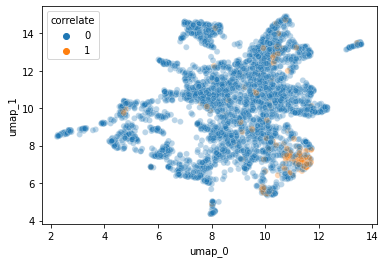

In [75]:
import seaborn as sns 
plot_df = score_dp[["umap_0", "umap_1", "correlate", "target"]].to_pandas()

sns.scatterplot(data=plot_df, x="umap_0", y="umap_1", hue="correlate", alpha=0.3)

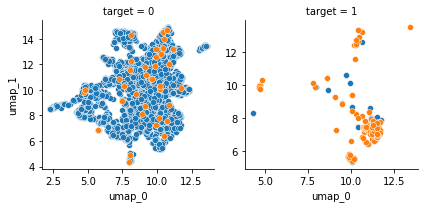

In [81]:
g = sns.FacetGrid(plot_df, col="target", hue="correlate", sharex=False, sharey=False)
g.map(sns.scatterplot, "umap_0", "umap_1")

In [134]:
words_dp

,word (PandasSeriesColumn),frequency (PandasSeriesColumn),index (PandasSeriesColumn),tokens (LambdaColumn),emb (TensorColumn)
0,the,151983633,0,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
1,the,151983633,1,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
2,of,71874676,2,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
3,of,71874676,3,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
4,and,62210193,4,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
...,...,...,...,...,...
9995,halves,6523,9995,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
9996,chemotherapy,6521,9996,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
9997,sizable,6519,9997,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
9998,shutout,6516,9998,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
